### Text-to-DSL: Natural language to OpenSearch DSL Query

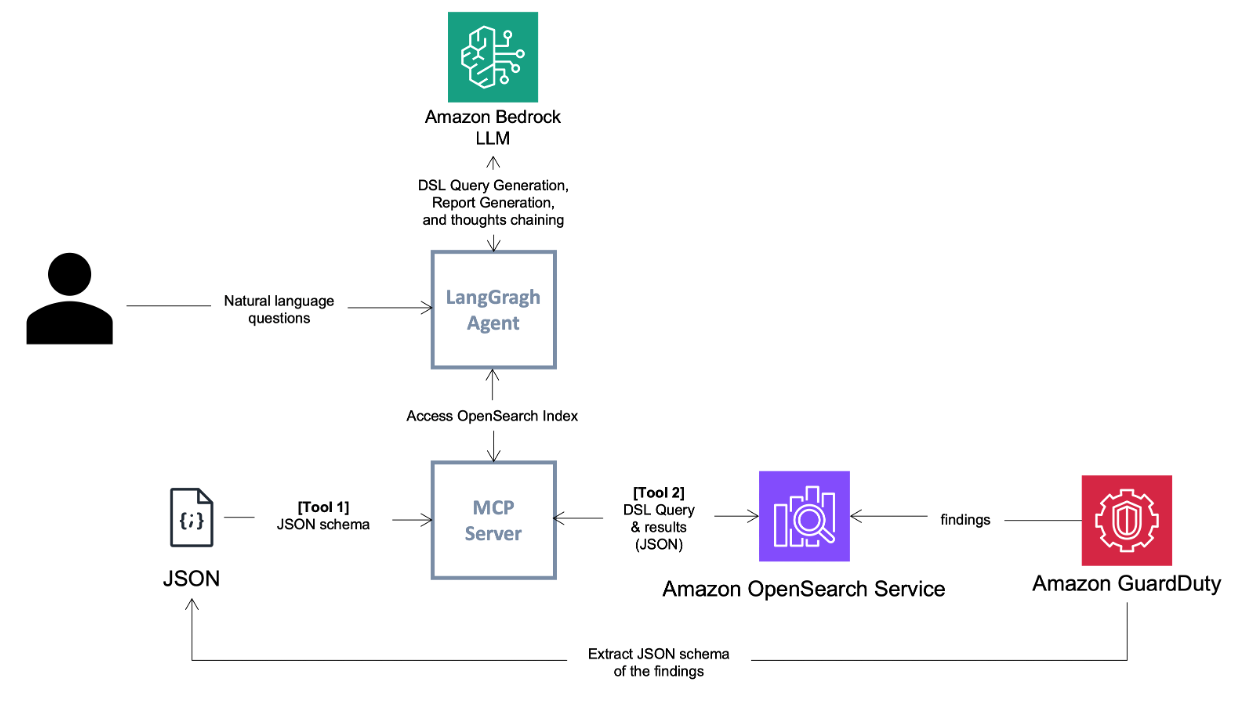

Amazon OpenSearch Service (OpenSearch) simplifies operating scalable log analytics and application monitoring. While the powerful Domain-Specific Language (DSL) enables complex searches and filtering, writing DSL queries requires extensive knowledge of the query language and metadata for complex JSON document structures.<br/>
This demo shows how an agentic workflow using Large Language Models (LLMs) and LangGraph can solve this problem. Users can search complex logs generated from Amazon GuardDuty, which contains cloud security threats, using natural language. The agentic workflow converts the user query into an enriched JSON query and retrieves the exact information.


[def]: attachment:image.png

#### Prerequisites

1. Create a OpenSearch Collection using oss-cfn.yaml. This will be merged to the workshop account init template so event attendees will have a pre-configured collection in each account.
2. Install MCP and python packages

In [ ]:
!pip install -r requirements.txt --quiet --upgrade

In [ ]:
# Get your region name
import boto3
region = boto3.Session().region_name

# Followings are the collection & index names we will use.
collection_name = "agent-ws-collection"
index_name = "guardduty-index"

#### Step1: Load AWS GuardDuty sample findings to OpenSearch collection

In [ ]:
# Load sample findings
from utils import (
    create_sample_findings,
    get_guardduty_findings
)
from IPython.display import display, JSON

create_sample_findings()
guardduty_findings = get_guardduty_findings()

# Show one sample finding
print('-------------------------------------------------')
display(JSON(guardduty_findings[0]))

In [ ]:
# Ingest to OpenSearch Serverless Collection
from utils import (
    create_oss_index,
    index_document_oss,
)
from time import sleep

# Create an index
print(create_oss_index(collection_name=collection_name, index_name=index_name))

# Wait until the index is created
print("Waiting...")
sleep(5)

# Index the findings into the collection
for idx, finding in enumerate(guardduty_findings):
    ingest_response = index_document_oss(idx+1, finding, collection_name, index_name)
    print(str(ingest_response)+" \r", end="")

print("\nIngestion Completed!")

In [ ]:
# Validation by running a simple query, which will retrive any findings with "Kubernetes" in its title.
from utils import query_opensearch_with_dsl
from IPython.display import display, JSON

# This is a simple DSL query example, finding records with "Kubernetes" in its title
basic_match_dsl_query = {
    "query": {
        "match": {
            "Title": "Kubernetes"
        }
    }
}

display(JSON(query_opensearch_with_dsl(collection_name, index_name, basic_match_dsl_query)[0]))

#### Step2. Try simple MCP Client-Server
An MCP server code is in ```mcp_dsl_server.py```. <br/> 
We will use this server for Text-to-DSL later. In this section, we will try a simple query to see how MCP server works.<br/>
The MCP server has three "tools":
* add_two_numbers: Add two integers and returns a string.
* query_dsl: We will use this later in this notebook.
* get_index_schema: We will use this later in this notebook.

In [ ]:
# Simple experiment to see how MCP works.

from mcp import ClientSession, StdioServerParameters, types
from mcp.client.stdio import stdio_client
import asyncio
import boto3
import textwrap
from IPython.display import display, Markdown

# Create server parameters for stdio connection
server_params = StdioServerParameters(
    command="python",  # Executable
    args=["mcp_dsl_server.py"],  # Optional command line arguments
)


async with stdio_client(server_params) as (read, write):
    async with ClientSession(
        read, write
    ) as session:
        # Initialize the connection
        await session.initialize()

        # List available tools
        tools = await session.list_tools()
        # Call a tool
        result = await session.call_tool("add_two_numbers", arguments={"a": 19, "b": 77})


        display(Markdown(textwrap.dedent(f"""#### This MCP server provides following tools.
| Name | Desc | Args |
| --- | --- | --- |
{ "\n".join(["|" + i.name + "|" + i.description + "|" + str(i.inputSchema['required']) + "|" for i in tools.tools]) }
#### Return
{result.content[0].text}
        """)))

#### Step 3. Create an agentic workflow to query OpenSearch Index

In [ ]:
# We will use the same MCP server from the above, this time we are using the main functions of it for DSL query.

from langgraph.prebuilt import create_react_agent
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
import textwrap

async def query_opensearch(query_text, llm):
    credentials = boto3.Session().get_credentials()
    # Create server parameters for stdio connection
    server_params = StdioServerParameters(
        command="python",  # Executable
        args=["mcp_dsl_server.py"],  # Optional command line arguments
        env={
            "AWS_ACCESS_KEY_ID": credentials.access_key,
            "AWS_SECRET_ACCESS_KEY": credentials.secret_key,
            "AWS_SESSION_TOKEN": credentials.token,
            "AWS_DEFAULT_REGION": region
        },  # Optional environment variables
    )

    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            # Initialize the connection
            await session.initialize()
            # Get tools
            tools = await load_mcp_tools(session)
            # Create and run the agent
            agent = create_react_agent(llm, tools)

            message = textwrap.dedent("""
Write a DSL query to retrive data from guardduty-index for the following question. 
Check the schema of the index to write accurate and concise queries.
Remember a value of the attribute $.hits.total.value is the count of found items.
<Question>{query}</Question>

Format your answer as a Markdown report consists of four sections:
1. A DSL query that was used.
2. Summarized answer for the question.
3. Tabular format of the findings.
4. Recommended remediations based on your knowledge
""")
            
            agent_response = await agent.ainvoke({"messages": message.format(query=query_text)})
    return agent_response

In [ ]:
# Create server parameters for stdio connection
import boto3
from botocore.client import Config
from langchain_aws import ChatBedrockConverse, ChatBedrock

# Set bedrock configs
bedrock_config = Config(
    connect_timeout=120, read_timeout=120, retries={"max_attempts": 2}
)

# Create a bedrock runtime client
bedrock_rt = boto3.client(
    "bedrock-runtime", region_name=region, config=bedrock_config
)

# Initialize the Bedrock model
llm = ChatBedrock(
    client=bedrock_rt,
    model="us.anthropic.claude-3-5-sonnet-20241022-v2:0" if region=="us-west-2" else 
          "us.anthropic.claude-3-5-haiku-20241022-v1:0",
    temperature=0,
    max_tokens=5019,
)

In [ ]:
# Query 1: A straightforward query with filtering conditions
query = "what were the security threats on EKS with secerity higher than 6."

response = await query_opensearch(query, llm)

from IPython.display import display, Markdown

display(Markdown(response["messages"][-1].content))

In [ ]:
# Query 2: A straightforward query with filtering conditions
query = "Find suspicious user names in EKS clusters."

response = await query_opensearch(query, llm)

from IPython.display import display, Markdown

display(Markdown(response["messages"][-1].content))

In [ ]:
# Query 3: A fuzzy qustion which can be translated to multiple keywords
query = "Any Cryptocurrency related activities found in our clusters?"

response = await query_opensearch(query, llm)

from IPython.display import display, Markdown

display(Markdown(response["messages"][-1].content))

In [ ]:
# Query 4: Aggregation
query = "How many of very severe (8<) threats found?"

response = await query_opensearch(query, llm)

from IPython.display import display, Markdown

display(Markdown(response["messages"][-1].content))

In [ ]:
# Query 5: A drill down question
query = "Which Outpost has been involved with cryptocurrency activities?"

response = await query_opensearch(query, llm)

from IPython.display import display, Markdown

display(Markdown(response["messages"][-1].content))

## Optional: Try Strands Agents

Following example uses Strands Agents instead of LangGraph

In [ ]:
from strands import Agent
from strands.tools.mcp import MCPClient
from mcp import stdio_client, StdioServerParameters
import boto3
from IPython.display import display, Markdown

# Define a system prompt
SYSTEM_PROMPT = """
Write a DSL query to retrive data from guardduty-index for the following question. 
Check the schema of the index to write accurate and concise queries. 

Format your answer as a Markdown report consists of four sections:
1. A DSL query that was used.
2. Summarized answer for the question.
3. Tabular format of the findings.
4. Recommended remediations based on your knowledge
"""
credentials = boto3.Session().get_credentials()
server_params = StdioServerParameters(
        command="python",  # Executable
        args=["mcp_dsl_server.py"],  # Optional command line arguments
        env={
            "AWS_ACCESS_KEY_ID": credentials.access_key,
            "AWS_SECRET_ACCESS_KEY": credentials.secret_key,
            "AWS_SESSION_TOKEN": credentials.token
        },  # Optional environment variables
    )

# Load an MCP server that can query OpenSearch Index with DSL
opensearch_tool = MCPClient(lambda: stdio_client(server_params))

with opensearch_tool:
    agent = Agent(
        system_prompt=SYSTEM_PROMPT,
        tools=opensearch_tool.list_tools_sync()
    )

    display(Markdown(agent("Any cryptocurrency related activities happening in EKS clusters?").message["content"][0]["text"]))